# Reference Architecture for LLM applications using Redis & Amazon Web Service

<a href="https://colab.research.google.com/github/RedisVentures/redis-google-llms/blob/main/BigQuery_Palm_Redis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook serves as a getting-started guide for working with LLMs on Amazon Web Service (AWS) with Redis Enterprise.

## Intro

Amazon Bedrock is a fully managed service that offers a choice of high-performing foundation models (FMs) from leading AI companies like AI21 Labs, Anthropic, Cohere, Meta, Stability AI, and Amazon with a single API, along with a broad set of capabilities you need to build generative AI applications, simplifying development while maintaining privacy and security. With the comprehensive capabilities of Amazon Bedrock, you can easily experiment with a variety of top FMs, privately customize them with your data using techniques such as fine-tuning and retrieval augmented generation (RAG), and create managed agents that execute complex business tasks—from booking travel and processing insurance claims to creating ad campaigns and managing inventory—all without writing any code. Since Amazon Bedrock is serverless, you don't have to manage any infrastructure, and you can securely integrate and deploy generative AI capabilities into your applications using the AWS services you are already familiar with.

Redis Enterprise offers robust vector database features, with an efficient API for vector index creation, management, distance metric selection, similarity search, and hybrid filtering. When coupled with its versatile data structures - including lists, hashes, JSON, and sets - Redis Enterprise shines as the optimal solution for crafting high-quality Large Language Model (LLM)-based applications. It embodies a streamlined architecture and exceptional performance, making it an instrumental tool for production environments.



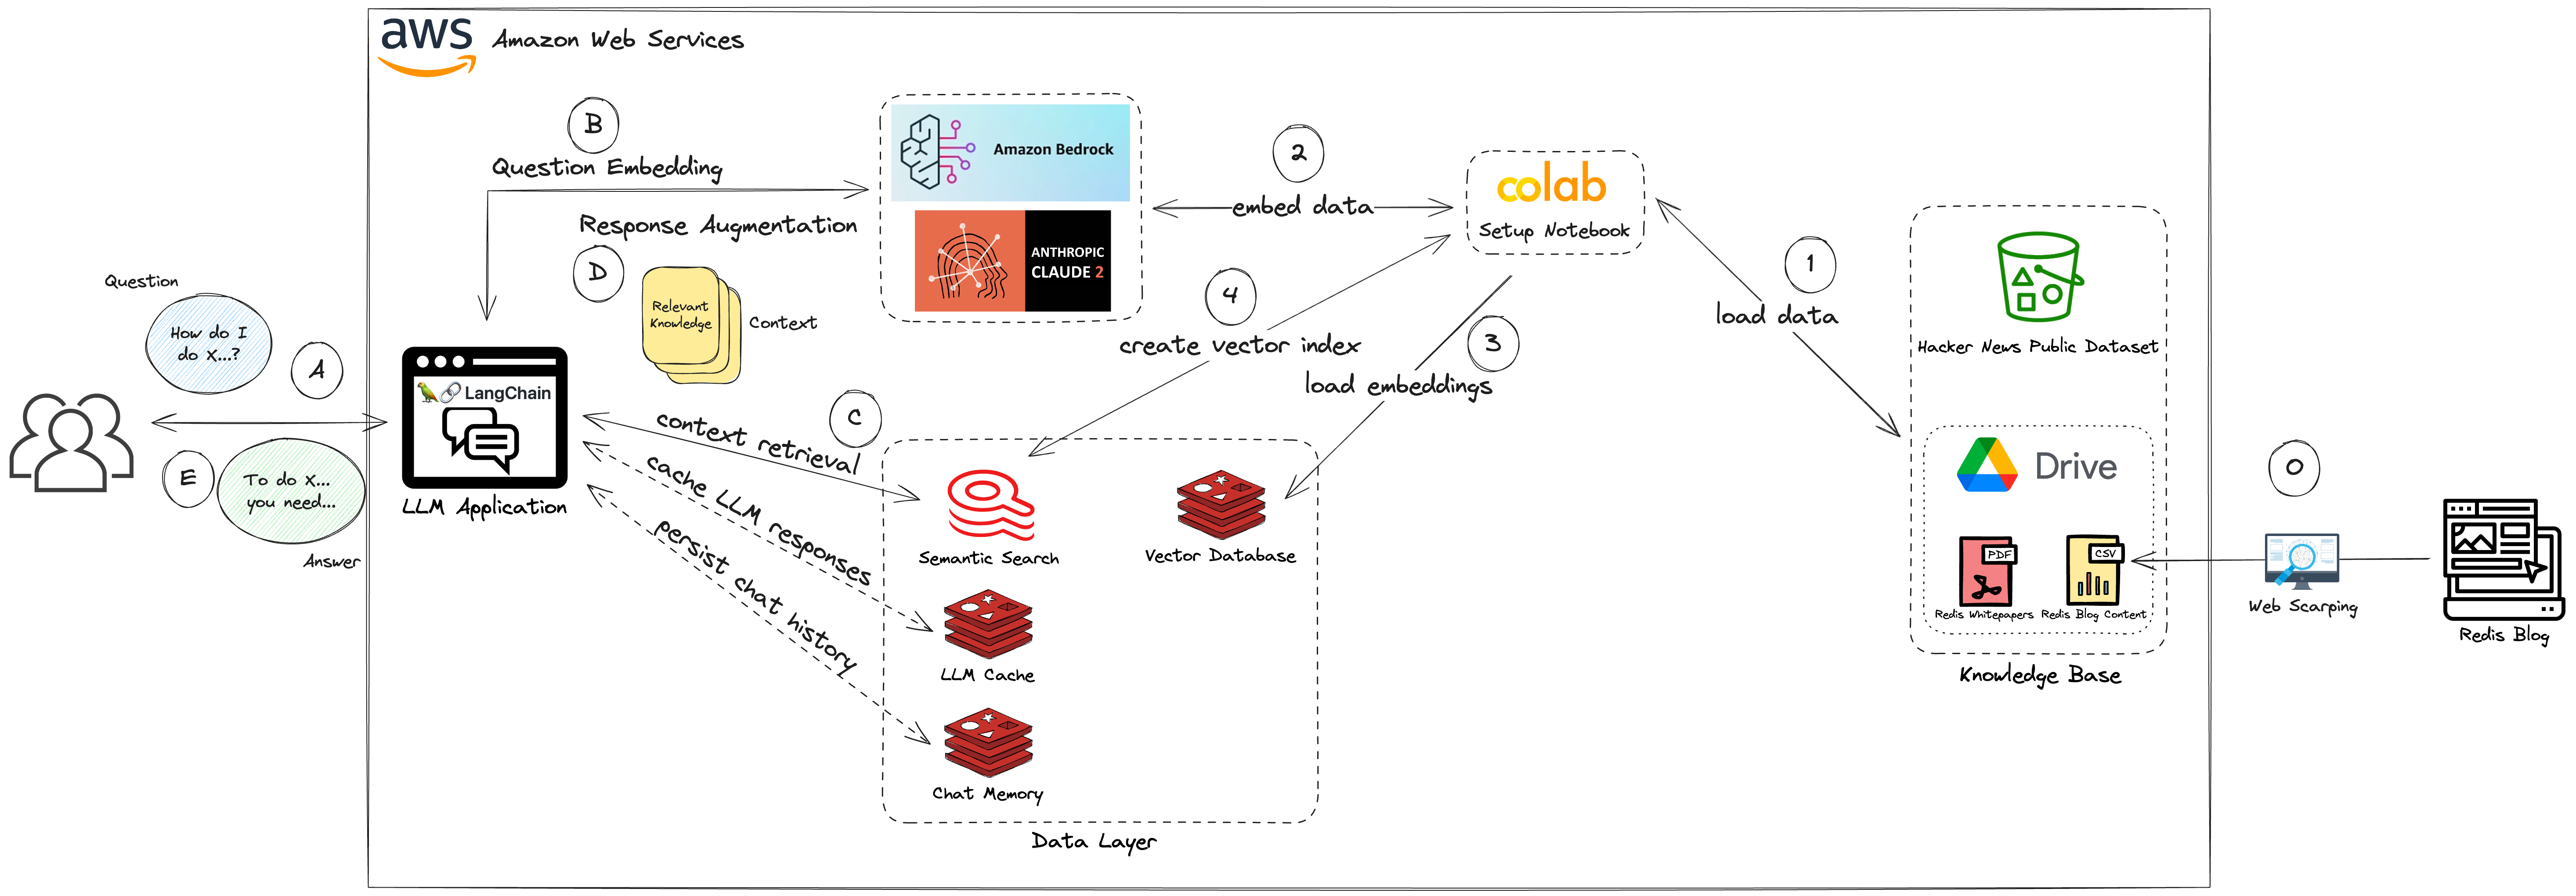

Below we will work through several design patterns with AWS Bedrock LLMs and Redis Enterprise that will ensure optimal production performance.


___
## Contents
- Prerequisites
    1. Install required libraries
    2. Import Libraries
    3. Load Working Files from Github
    4. Mount Google Drive (Optional)
    5. Authenticate to AWS Bedrock
    6. Validate the connection
    7. Install Redis locally (Optional)
    8. Connect to Redis Cluster
- LLM Application: Domain-Specific ChatBOT
    1. Documents Loading
      - Loading Redis Whitepapers (PDF)
      - Loading Redis Blog (URLs)
    2. Splitting
    3. Vector Storage & Indexing
    4. Retrieval    
      - Simple Similarity Search     
      - Retrieval Augmented Generation (RAG)
      - LLM Caching
        - Standard Caching
        - Semantic Caching
      - QA History
- User Interface
- Cleanup
___

# Prerequisites

Before we begin, we must install some required libraries, authenticate with Google, create a Redis database, and initialize other required components.


## 1. Install required libraries

In [5]:
! pip install langchain sentence_transformers pypdf tenacity redis redisvl gradio "google-cloud-aiplatform==1.25.0" --upgrade --user

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached tenacity-8.2.3-py3-none-any.whl (24 kB)
  Using cached gradio-4.7.1-py3-none-any.whl (16.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00
  Using cached gradio_client-0.7.0-py3-none-any.whl (302 kB)
INFO: pip is looking at multiple versions of gradio to determine which version is compatible with other requirements. This could take a while.
  Using cached gradio-4.5.0-py3-none-any.whl (16.5 MB)
  Using cached gradio-4.4.1-py3-none-any.whl (15.4 MB)
  Using cached gradio-4.4.0-py3-none-any.whl (15.4 MB)
  Using cached gradio-4.3.0-py3-none-any.whl (15.4 MB)
  Using cached gradio-4.2.0-py3-none-any.whl (15.4 MB)
  Using cached gradio-4.1.2-py3-none-any.whl (15.4 MB)
  Using cached gradio-4.1.1-py3-none-any.whl (15.4 MB)
INFO: pip is looking at multiple versions of gradio to determine which version is compatible with oth

^^^ If prompted press the Restart button to restart the kernel.^^^

In [2]:
%pip install boto3 botocore

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 9.5 MB/s eta 0:00:00


## 2. Import libraries

In [6]:
from glob import glob
from langchain.document_loaders import PyPDFLoader
from langchain.document_loaders import DataFrameLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.redis import Redis as RedisVectorStore
from redisvl.llmcache.semantic import SemanticCache
from langchain.embeddings import BedrockEmbeddings
from langchain.llms import Bedrock
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from google.colab import auth
from getpass import getpass
from google.colab import drive
from google.cloud import bigquery
from tenacity import retry, stop_after_attempt, wait_random_exponential
from typing import Generator, List, Any
from redis.commands.search.query import Query
from redis.commands.search.field import (
    NumericField,
    TagField,
    TextField,
    VectorField,
)
from redis.commands.search.indexDefinition import (
    IndexDefinition,
    IndexType
)
import boto3
import redis
import json
import logging
import hashlib
import random
import gradio as gr
import os
import sys
import pandas as pd
import numpy as np

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [7]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## 3. Load Working Files from Github

In [8]:
!npx degit aelkouhen/redis-vss/ColabDrive -f

npx: installed 1 in 2.602s
> destination directory is not empty. Using --force, continuing
> cloned aelkouhen/redis-vss#HEAD


## 4. Mount Google Drive (Optional)

Optionally, you can load the working files from Google Drive.

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## 5. Authenticate to AWS Bedrock

In [9]:
ACCESS_ID = getpass("ACCESS_ID:")
ACCESS_KEY = getpass("ACCESS_KEY:") 
REGION = 'us-west-2'

ACCESS_ID:··········
ACCESS_KEY:··········


In [39]:
session = boto3.Session(
aws_access_key_id=ACCESS_ID,
aws_secret_access_key=ACCESS_KEY,
region_name=REGION
)

bedrock = boto3.client('bedrock', region_name=REGION, aws_access_key_id=ACCESS_ID, aws_secret_access_key=ACCESS_KEY)
bedrock_runtime = boto3.client('bedrock-runtime', region_name=REGION, aws_access_key_id=ACCESS_ID, aws_secret_access_key=ACCESS_KEY)

## 6. Validate the connection

We can check the client works by trying out the `list_foundation_models()` method, which will tell us all the models available for us to use

In [17]:
bedrock.list_foundation_models()

{'ResponseMetadata': {'RequestId': 'fbd14955-f81e-4266-80f5-c4dbd96e19ae',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Thu, 23 Nov 2023 13:38:45 GMT',
   'content-type': 'application/json',
   'content-length': '8060',
   'connection': 'keep-alive',
   'x-amzn-requestid': 'fbd14955-f81e-4266-80f5-c4dbd96e19ae'},
  'RetryAttempts': 0},
 'modelSummaries': [{'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-tg1-large',
   'modelId': 'amazon.titan-tg1-large',
   'modelName': 'Titan Text Large',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['TEXT'],
   'responseStreamingSupported': True,
   'customizationsSupported': ['FINE_TUNING']},
  {'modelArn': 'arn:aws:bedrock:us-west-2::foundation-model/amazon.titan-embed-g1-text-02',
   'modelId': 'amazon.titan-embed-g1-text-02',
   'modelName': 'Titan Text Embeddings v2',
   'providerName': 'Amazon',
   'inputModalities': ['TEXT'],
   'outputModalities': ['EMBEDDING'],
   'customiza

## 7. Install Redis locally (Optional)
If you have a Redis db running elsewhere with [Redis Stack](https://redis.io/docs/about/about-stack/) installed, you don't need to run it on this machine. You can skip to the "Connect to Redis server" step.

You can install Redis-Stack locally using the following block:

In [18]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


In [19]:
# Redis connection params
redis_url = "redis://127.0.0.1:6379"

## 8. Connect to Redis server
Replace the connection params below with your own if you are connecting to an external Redis instance.

In [ ]:
# Redis connection params
#redis_url = "redis://redis-12000.cluster.dev-vss.demo.redislabs.com:12000"

In [21]:
# Create Redis client
redis_client = redis.from_url(redis_url)

# Test connection
redis_client.ping()

True

In [22]:
# Clear Redis database (optional)
redis_client.flushdb()

True

# LLM Application: Domain-Specific ChatBot

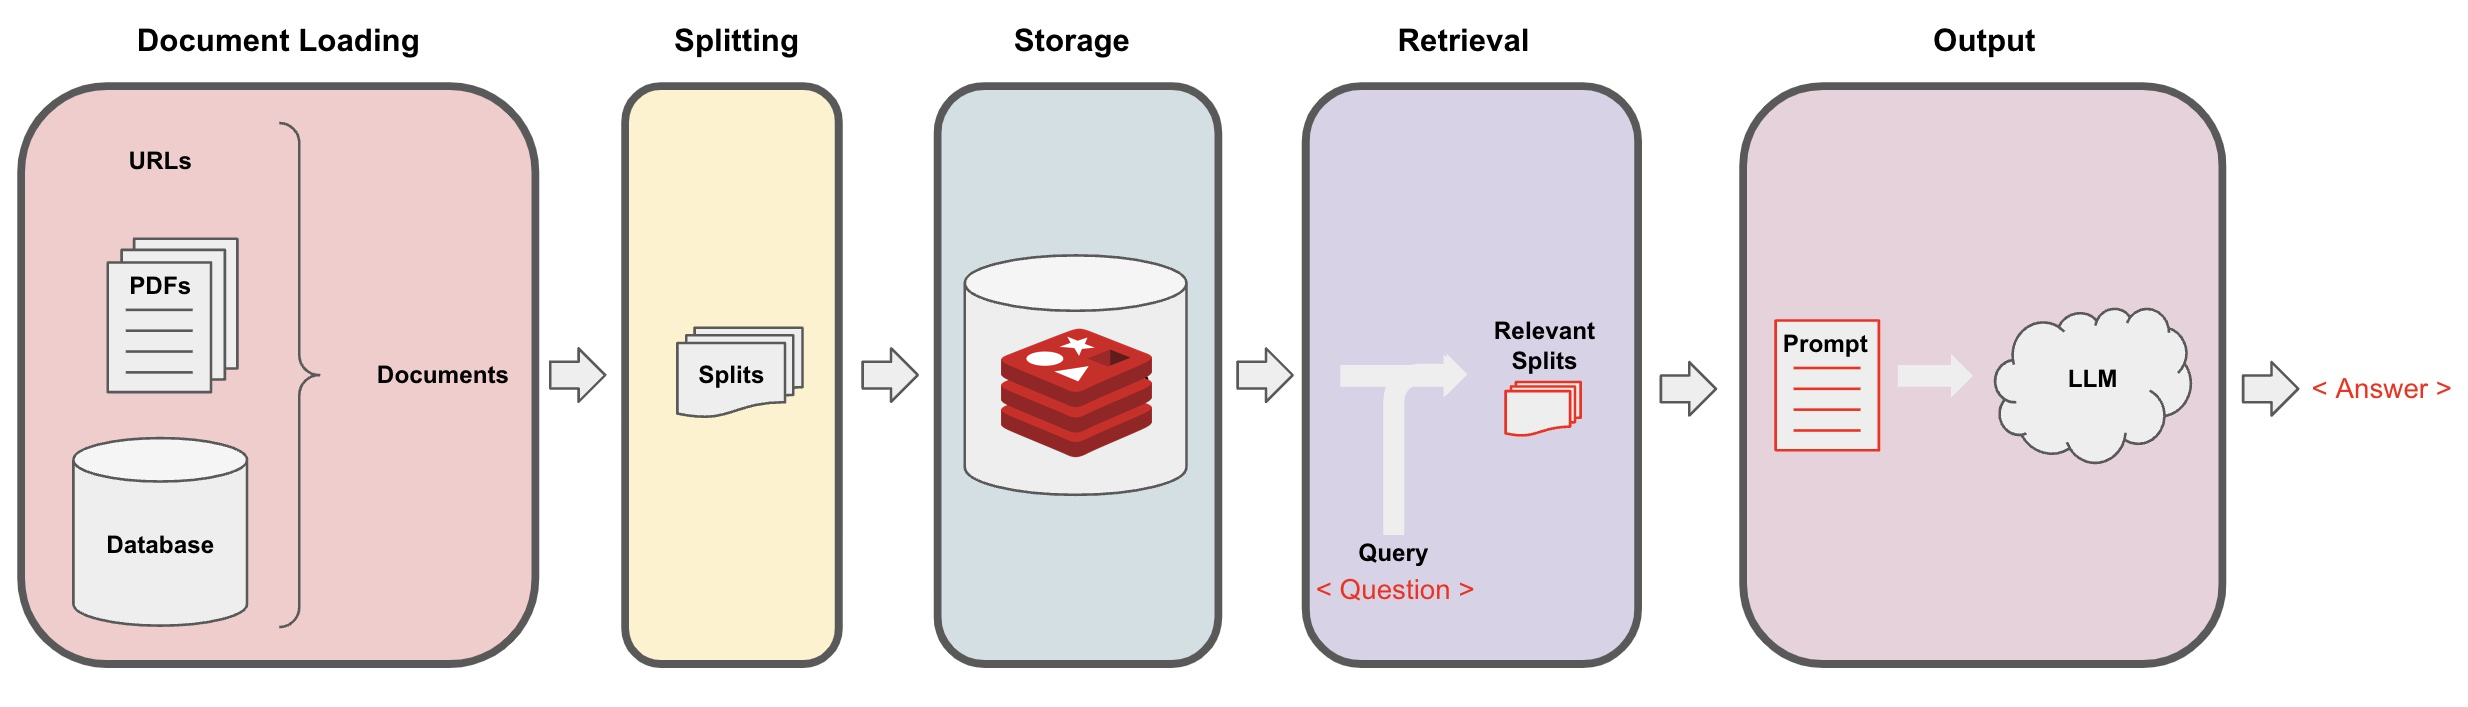

## 1. Documents Loading

### Loading Redis Whitepapers (PDF)
Let's load Redis Whitepapers (PDF document)

In [23]:
pages = []

In [24]:
dir = os.path.join("docs/pdf", "*.pdf")
loaders = [PyPDFLoader(file) for file in glob(dir)]

for loader in loaders:
    pages.extend(loader.load())

Each PDF page is a `Document`.

A `Document` contains text (`page_content`) and `metadata`.

In [25]:
len(pages)

48

In [26]:
print(pages[3].page_content)

Redis Solution Brief / Cache and Message Broker for Microservices4
© 2023 Redis
Let's explore how a customer online dating 
application can work using Redis Enterprise to 
cache session data.
1. The client is the user interface. The application 
is available on desktop, mobile web, Android, 
and iOS. 
2. A user logs in with their credentials.
3. Two tokens are created with user 
authentication and session data: an access 
token and a refresh token. These tokens are 
cached in Redis Enterprise. The access token 
contains authentication data, user information, 
and permissions; the API uses it during the 
user session. The token has a two-day time-
to-live (TTL). Once the authentication token 
expires, a new access token is (or can be) 
generated from a refresh token, which has 
a longer TTL; it keeps users logged in if they 
have enabled the “keep me logged in” setting.
4. The API gateway manages calls from the 
many microservices that power the online 
dating application. When a reques

In [27]:
print(pages[3].metadata)

{'source': 'docs/pdf/cache-and-message-broker-for-microservices-solution-brief.pdf', 'page': 3}


### Loading Redis Blog (URLs)

Let's load the Redis Blog posts

1. Extract the Redis blog posts into a CSV file.

In [ ]:
!python extract_redis_blog.py

Retrieving blogs after 2023-07-01T00:00:00+00:00
Processing post URL : 
https://redis.com/blog/cloud-migration-strategy-misconceptions/
Processing post URL : https://redis.com/blog/redisgraph-eol/
Processing post URL : 
https://redis.com/blog/i-have-500-million-keys-but-whats-in-my-redis-db/
Processing post URL : 
https://redis.com/blog/how-to-use-redis-at-least-x1000-more-efficiently/
Processing post URL : 
https://redis.com/blog/turbo-boost-wordpress-with-a-secure-memcached-plugin/
Processing post URL : 
https://redis.com/blog/top-redis-headaches-for-devops-client-buffers/
Processing post URL : 
https://redis.com/blog/pop-the-red-boxs-lid-redis-lua-debugger/
Processing post URL : 
https://redis.com/blog/the-7th-principle-of-redis-we-optimize-for-joy/
Processing post URL : 
https://redis.com/blog/enabling-secure-connections-redis-enterprise-cloud-python
/
Processing post URL : https://redis.com/blog/use-redis-content-filtering/
Processing post URL : https://redis.com/blog/write-redis-

2. Load Blog Posts as WebDocs

Each Blog Post is a `Document`.

A `Document` contains text (`page_content`) and `metadata`.

In [28]:
df = pd.read_csv("docs/csv/redis_blogs.csv")
df_loader = DataFrameLoader(df, page_content_column="text")

pages.extend(df_loader.load())

In [29]:
len(pages)

68

In [30]:
print(pages[48].page_content)

There are several ways to classify and understand data architectures, each with its own pros and cons. They can help you make an informed decision about the best design for your needs. Here, I explain velocity-based data architectures, and where they fit in the grand scheme of things.The two most popular velocity-based architectures are Lambda and Kappa. Data architectures are also classified based on their operational mode or topology, including data fabric, data hub, and data mesh–but I leave that explanation to a later blog post.Data architecture is an element in enterprise architecture, inheriting its main properties: processes, strategy, change management, and evaluating trade-offs. According to the Open Group Architecture Framework, data architecture is “a description of the structure and interaction of the enterprise’s major types and sources of data, logical data assets, physical data assets, and data management resources.”Per the Data Management Body of Knowledge, data archite

In [31]:
print(pages[48].metadata)

{'id': 1, 'url': 'https://redis.com/blog/velocity-based-data-architectures/', 'title': 'An Introduction to Velocity-Based Data Architectures', 'date': 'August 7, 2023', 'author': 'Amine El Kouhen'}


## 2. Splitting

We will use `RecursiveCharacterTextSplitter` and also add lookback period as seperator

In [32]:
r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=5000,
    chunk_overlap=100,
    separators=["\n\n", "\n", "(?<=\. )", " ", ""],
)

In [33]:
docs = r_splitter.split_documents(pages)

In [34]:
len(pages)

68

In [35]:
len(docs)

80

## 3. Vector Storage & Indexing

Here, we create embeddings that represent the texts in our documents (PDF and URLs) and store them in Redis. Then, we will create a secondary index that enables efficient search over the embeddings. To learn more about the vector similarity features in Redis, check out these docs and these Redis AI resources.

Why do we need to enable search??? Using Redis for vector similarity search allows us to retrieve chunks of text data that are similar or relevant to an input question or query. This will be extremely helpful for our sample generative ai / LLM application.

In [36]:
# Redis index name
INDEX_NAME = "redis"

In [40]:
bedrock_model = BedrockEmbeddings(model_id="amazon.titan-embed-text-v1", client = bedrock_runtime)

In [41]:
redis_vector_db = RedisVectorStore.from_documents(documents=docs,
                                                  index_name=INDEX_NAME,
                                                  embedding=bedrock_model,
                                                  redis_url=redis_url)

## 4. Retrieval

### Simple Similarity Search

**Semantic Search**, in the context of Large Language Models (LLMs), is a sophisticated search technique that goes beyond *literal* keyword matching to understand the contextual meaning and intent behind user queries. Leveraging the power of AWS's Bedrock platform and Redis' vector database capabilities, semantic search can map and extract deep-level knowledge from vast text datasets, including nuanced relationships and hidden patterns.

This allows applications to return search results that are contextually relevant, enhancing user experience by offering meaningful responses, even to complex or ambiguous search terms. Thus, semantic search not only boosts the accuracy and relevancy of search results but also empowers applications to interact with users in a more human-like, intuitive manner.

The general process of semantic search includes 3 steps:
1. Create query vector
2. Perform vector search
3. Review and return results


In [49]:
# 1. Create query vector
query = "What is RedisBloom?"

query_vector = bedrock_model.embed_query(query)

# Our query has been converted to a list of floats (this is a truncated view)
query_vector[:10]

[-0.43359375,
 0.0023498535,
 0.74609375,
 0.096191406,
 0.27148438,
 0.28320312,
 -0.1484375,
 0.00019741058,
 -0.71484375,
 0.115722656]

In [50]:
docs = redis_vector_db.similarity_search_with_score(query, k=3)

In [51]:
df = pd.DataFrame([(t.__dict__, 1-s) for t, s in docs], columns =['page_content', 'score'])
df['document'] = df['page_content'].apply(lambda x: x['metadata']).apply(lambda y: y['id'])
df['page_content'] = df['page_content'].apply(lambda x: x['page_content'])

In [52]:
display(df)

page_content   score  \
0  About Redis\nData is the lifeline of every bus...  0.6154   
1  Redis is committed to making using our softwar...  0.5882   
2  10Next Steps \nData is the lifeline of every b...  0.5578   

                                     document  
0  doc:redis:33f134f0c67b4cc89c99125cff3f1632  
1  doc:redis:7be6ce1cc9e445c8a465ea2b89dcb4f8  
2  doc:redis:3f70b3fff2e64e358f89923e2f008de1

### Retrieval Augmented Generation (RAG)

Retrieval Augmented Generation (RAG), within the scope of Large Language Models (LLMs), is a technique that combines the knowledge of domain-specific data and generative models to enhance the production of contextually-rich question responses. In essence, RAG functions by retrieving relevant information from a knowledge base of documents or data before proceeding to generate a response. This allows generalized foundation models to gain access to these datasources at runtime, and is NOT the same thing as fine-tuning.




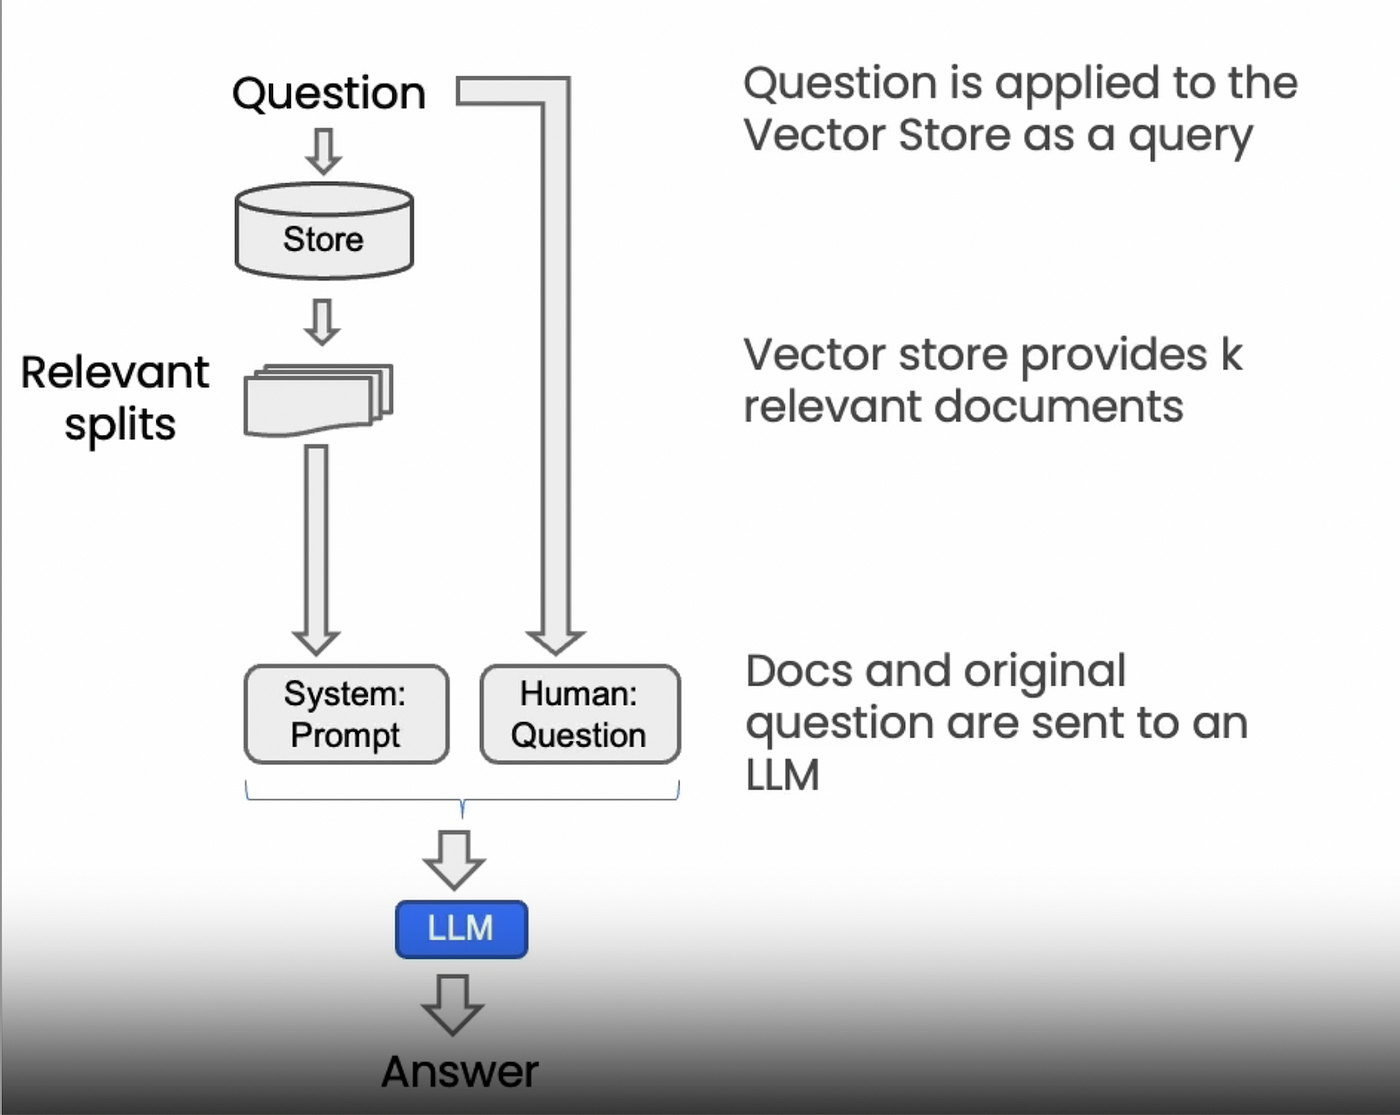

RAG exploits the strengths of Redis as a low-latency vector database for efficient retrieval operations and AWS's Bedrock to generate a coherent text response. In LLM applications, RAG enables a deeper comprehension of context, returning highly nuanced responses, even to intricate queries. This pattern enhances the interactive capability of applications, delivering more precise and informative responses, thereby significantly enriching the user experience.

In order to build a RAG pipeline for question answering, we need to use Bedrock API with for text generation (`anthropic.claude-v2`).

In [53]:
# We will be using the Titan Embeddings Model to generate our Embeddings.
llm = Bedrock(model_id="anthropic.claude-v2", client=bedrock_runtime)

In [54]:
prompt_data="""What is a large language model?"""

conversation = ConversationChain(
    llm=llm, verbose=True, memory=ConversationBufferMemory()
)

conversation.predict(input=prompt_data)



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: What is a large language model?
AI:

> Finished chain.


" A large language model is a type of natural language processing (NLP) model that is trained on a large amount of text data. Some key characteristics of large language models:\n\n- They contain billions or trillions of parameters, allowing them to model very complex language relationships. Popular large models include GPT-3, Jurassic-1, and Megatron-Turing NLG.\n\n- They are trained in a self-supervised way, learning patterns from unlabeled text data like books, websites, and social media posts. This allows them to build a broad understanding of language.\n\n- They use transformer architectures which have attention mechanisms allowing them to learn contextual relationships between words and sentences. \n\n- They can perform a variety of NLP tasks like text generation, translation, summarization and question answering, without needing to be fine-tuned for each specific task.\n\n- They often demonstrate capabilities like understanding context, knowledge, reasoning and common sense that 

In order to be able to answer questions **while referencing domain-specific sources** (like our sample hackernews dataset), we must build a RAG pipeline:

1. First perform **Semantic Search** with the user query on the knowledge base (stored in Redis) to find relevant sources that will help the language model answer and respond intelligently.

2. The sources (called context) are "stuffed" into the prompt (input).

3. The context is retrieved and passed to the LLM application to be augmented.

4. Lastly, the full prompt is passed on to the language model for text generation.

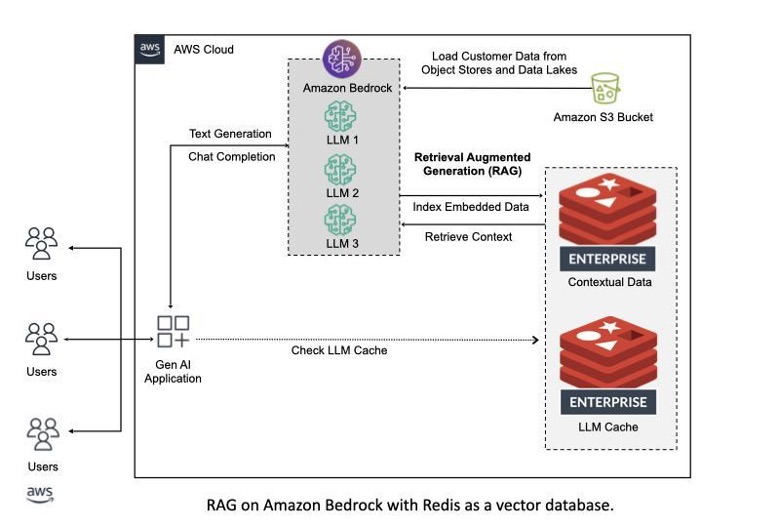

In [55]:
def create_prompt(prompt_template: str, **kwargs) -> str:
  return prompt_template.format(**kwargs)

def rag(query: str, prompt: str, verbose: bool = True) -> str:
    """
    Simple pipeline for performing retrieval augmented generation with
    AWS Bedrock Anthropic Claude API and Redis Enterprise.
    """
    # Perform a vector similarity search in Redis
    if verbose:
        print("Pulling relevant data sources from Redis", flush=True)
    relevant_sources = redis_vector_db.similarity_search_with_score(query, k=3)
    df_source = pd.DataFrame([(t.__dict__, 1-s) for t, s in relevant_sources], columns =['page_content', 'score'])
    df_source['document'] = df_source['page_content'].apply(lambda x: x['metadata']).apply(lambda y: y['id'])
    df_source['page_content'] = df_source['page_content'].apply(lambda x: x['page_content'])

    if verbose:
        print("Relevant sources found!", flush=True)
    # Combine the relevant sources and inject into the prompt
    sources_text = u"\U0001F449" + " \n\U0001F449".join([source for source in df_source['page_content']])
    full_prompt = create_prompt(
        prompt_template=prompt,
        sources=sources_text,
        query=query
      )
    if verbose:
        print("\nFull prompt:\n\n", full_prompt, flush=True)
    # Perform text generation to get a response from Bedrock API
    llm = Bedrock(model_id="anthropic.claude-v2", client=bedrock_runtime)

    conversation = ConversationChain(
        llm=llm, verbose=False, memory=ConversationBufferMemory()
    )
    return conversation.predict(input=full_prompt)

Below is an example prompt template. Feel free to edit and tweak the initial sentence that sets the context for the language model to perform the action we are anticipating. The process of tuning and iterating on prompt design is widely referred to as "*prompt engineering*".

In [56]:
PROMPT = """You are a helpful virtual technology and IT assistant. Use the sources below as relevant context to help answer the user question. Don't blindly make things up. If you don't know the answer, just say that you don't know, don't try to make up an answer. Keep the answer as concise as possible.

SOURCES:
{sources}

QUESTION:
{query}?

Answer:"""

In [58]:
query = "What is RDI?"
response = rag(query=query, prompt=PROMPT)
print(response)

Pulling relevant data sources from Redis
Relevant sources found!

Full prompt:

 You are a helpful virtual technology and IT assistant. Use the sources below as relevant context to help answer the user question. Don't blindly make things up. If you don't know the answer, just say that you don't know, don't try to make up an answer. Keep the answer as concise as possible.

SOURCES:
👉Redis is announcing the public preview release of Redis Data Integration (RDI). RDI lets developers offload a database to Redis Enterprise, mirror application data, and operate at in-memory speeds. And you don’t need to invest in coding or integration efforts.The underlying problem: Your existing database is too slow.You have a lot of applications, a growing number of users, increasing technical demands, and an unrelenting demand for real-time response. Redis Enterprise provides real-time access to data and it scales horizontally, but how do you keep your Redis cache in line with your database so that all qu

### LLM Caching

**LLM Caching** is an advanced strategy used to optimize the performance of Large Language Model (LLM) applications. Utilizing the ultra-fast, in-memory data store of Redis, LLM Caching enables the storage and quick retrieval of pre-computed responses generated by AWS's Bedrock (Anthropic Claude V2). This means the computationally expensive process of response generation, especially for repetitive queries, is significantly reduced, resulting in faster response times and efficient resource utilization. This pairing of AWS's powerful generative AI capabilities with Redis' high-performance caching system thus facilitates a more scalable and performant architecture for LLM applications, improving overall user experience and application reliability.

There are primarily two modes of caching for LLMs:
- Standard Caching
- Semantic Caching

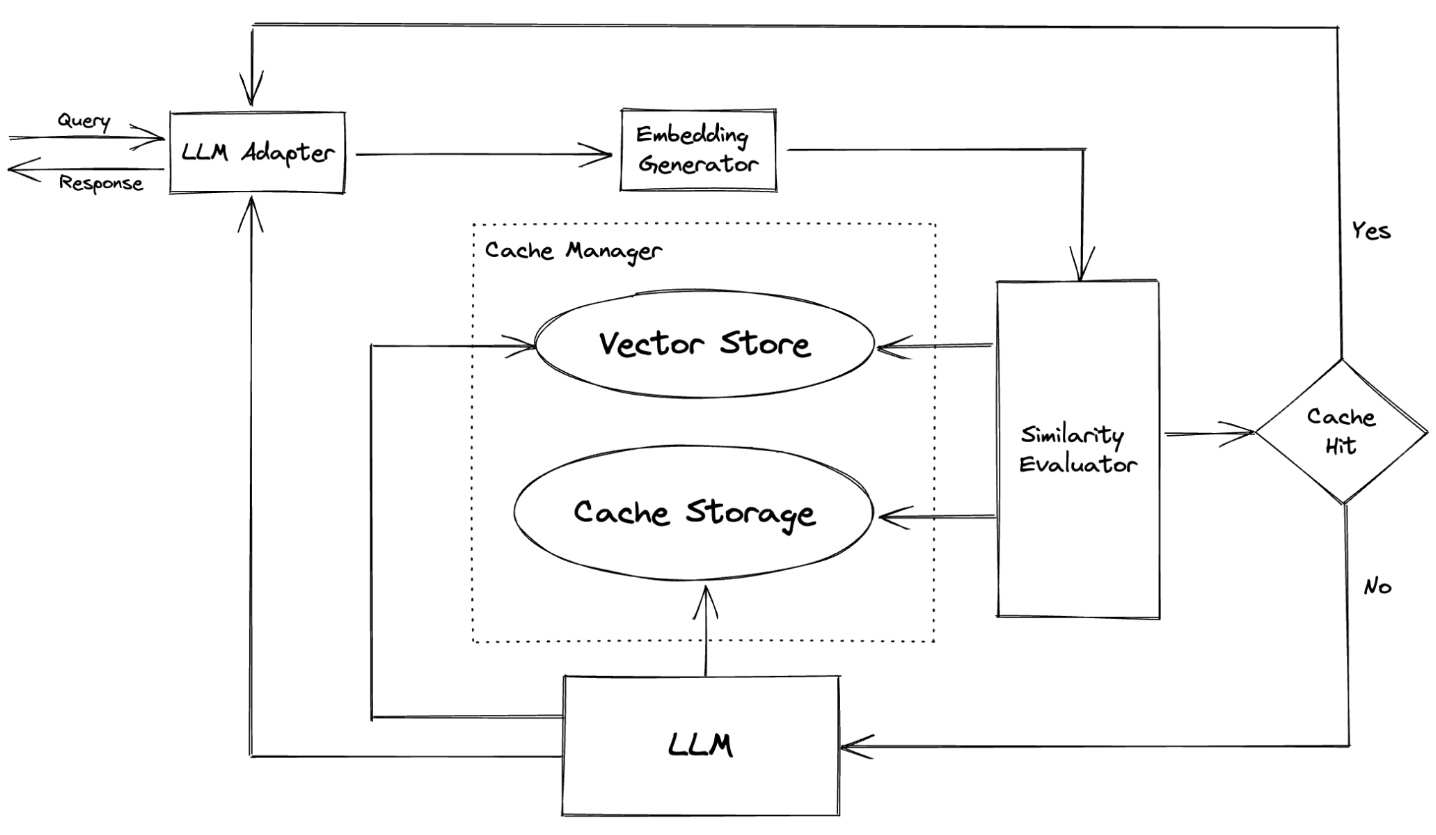

#### 1. Standard Caching

Standard caching for LLMs involves simply matching an exact phrase or prompt that has been provided before. We can return the previously used response from the LLM in order to speed up the throughput of the system overall and reduce redundant computation.

In [59]:
# Some boiler plate helper methods

def hash_input(prefix: str, _input: str):
    return prefix + hashlib.sha256(_input.encode("utf-8")).hexdigest()

def standard_check(key: str):
  # function to perform a standard cache check
    res = redis_client.hgetall(key)
    if res:
      return res[b'response'].decode('utf-8')

def cache_response(query: str, response: str):
    key = hash_input("std:llmcache:", query)
    redis_client.hset(key, mapping={"prompt": query, "response": response})

# LLM Cache wrapper / decorator function
def standard_llmcache(llm_callable):
    def wrapper(*args, **kwargs):
        # Check LLM Cache first
        key = hash_input("std:llmcache:", *args, **kwargs)
        response = standard_check(key)
        # Check if we have a cached response we can use
        if response:
            return response
        # Otherwise execute the llm callable here
        response = llm_callable(*args, **kwargs)
        cache_response(query, response)
        return response

    return wrapper

In [60]:
# Define a function that invokes the Bedrock API wrapped with a cache check

@standard_llmcache
def ask_claude(query: str):
  response = rag(query, PROMPT, verbose=False)
  return response

Now let's Ask our application:

In [61]:
%%time

query = "What is data mesh?"
ask_claude(query)

CPU times: user 112 ms, sys: 10.7 ms, total: 123 ms
Wall time: 12.6 s


" Data mesh is a decentralized data architecture framework proposed by Zhamak Dehghani that aims to distribute data ownership across business domains. The key principles of data mesh are:\n\n- Domain-oriented - Data is owned and managed by domain teams rather than a centralized data team. Each domain acts as a self-contained unit.\n\n- Data-as-a-product - Domains are responsible for the full lifecycle of their data products, treating data as a first class product.\n\n- Self-serve data infrastructure - Data infrastructure is democratized through APIs and services to enable domains to easily build, manage and serve their data products. \n\n- Federated computational governance - Lightweight governance protocols and standards facilitate interoperability between data products.\n\nIn summary, data mesh distributes data ownership to domains and empowers them to act as self-contained units that build, manage, govern and serve their own data products. It aims to accelerate analytics through dec

Now, if we ask the same question again -- we should get the same response in near real-time.

In [62]:
%%time

query = "What is data mesh?"
ask_claude(query)

CPU times: user 1.73 ms, sys: 0 ns, total: 1.73 ms
Wall time: 1.86 ms


" Data mesh is a decentralized data architecture framework proposed by Zhamak Dehghani that aims to distribute data ownership across business domains. The key principles of data mesh are:\n\n- Domain-oriented - Data is owned and managed by domain teams rather than a centralized data team. Each domain acts as a self-contained unit.\n\n- Data-as-a-product - Domains are responsible for the full lifecycle of their data products, treating data as a first class product.\n\n- Self-serve data infrastructure - Data infrastructure is democratized through APIs and services to enable domains to easily build, manage and serve their data products. \n\n- Federated computational governance - Lightweight governance protocols and standards facilitate interoperability between data products.\n\nIn summary, data mesh distributes data ownership to domains and empowers them to act as self-contained units that build, manage, govern and serve their own data products. It aims to accelerate analytics through dec

#### 2. Semantic Caching
Semantic caching builds off of the same concept as above but takes advantage of Redis' vector database features to lookup smenatically similar prompts that have been applied before -- this makes it possible to cache responses of queries that are very similar in meaning, but not necessarily using the exact same words + phrases. This widens the "hit rate", making LLM caching even more effective in practice.

In [63]:
# Some boiler plate helper methods

def semantic_check(cache: SemanticCache, query: str):
  # function to perform a semantic cache check
    cached_result = cache.check(prompt=query)
    return cached_result

def semantic_cache_response(cache: SemanticCache, query: str, response: str):
    cache.store(query, response)

# Semantic LLM Cache wrapper / decorator function
def semantic_llmcache(llm_callable):
    def wrapper(*args, **kwargs):
        cache = SemanticCache(redis_url=redis_url, distance_threshold=0.3)
        # Check Semantic LLM Cache first
        response = semantic_check(cache, query)
        # Check if we have a cached response we can use
        if response:
            print("Retrieving cached response...\n")
            return response[0]
        # Otherwise execute the llm callable here
        response = llm_callable(*args, **kwargs)
        semantic_cache_response(cache, query, response)
        return response

    return wrapper

In [64]:
# Define a function that invokes the PaLM API wrapped with a semantic cache check

@semantic_llmcache
def ask_claude_semantic(query: str):
  response = rag(query, PROMPT, verbose=False)
  return response

In [65]:
%%time

ask_claude_semantic(query = "What is data mesh?")

CPU times: user 468 ms, sys: 25.9 ms, total: 494 ms
Wall time: 26.4 s


' Data mesh is a decentralized data architecture that enables different business domains or units to manage their own data and data products independently. The key principles of data mesh are:\n\n- Domain-oriented - Data is owned and managed by domain teams rather than a centralized IT group. Each domain is responsible for its own data quality, governance, etc.\n\n- Data as a product - Data is treated as a product with well-defined specifications, SLAs, etc. Data consumers access data products through self-service.\n\n- Federated governance - Global standards and policies are set at the organization level, while each domain handles its own localized governance. \n\n- Self-serve data infrastructure - Domains can build, access and share their data products easily via infrastructure services for storage, processing, cataloging, security, etc.\n\nIn summary, data mesh distributes data ownership across business domains, enabling decentralized data management. It contrasts traditional centra

In [66]:
%%time

ask_claude_semantic(query = "Could you explain data products?")

Index already exists, not overwriting.
Retrieving cached response...

CPU times: user 122 ms, sys: 524 µs, total: 122 ms
Wall time: 128 ms


{'response': ' Data mesh is a decentralized data architecture that enables different business domains or units to manage their own data and data products independently. The key principles of data mesh are:\n\n- Domain-oriented - Data is owned and managed by domain teams rather than a centralized IT group. Each domain is responsible for its own data quality, governance, etc.\n\n- Data as a product - Data is treated as a product with well-defined specifications, SLAs, etc. Data consumers access data products through self-service.\n\n- Federated governance - Global standards and policies are set at the organization level, while each domain handles its own localized governance. \n\n- Self-serve data infrastructure - Domains can build, access and share their data products easily via infrastructure services for storage, processing, cataloging, security, etc.\n\nIn summary, data mesh distributes data ownership across business domains, enabling decentralized data management. It contrasts tradi

### QA History

Giving your application access to "memory" for chat history is a common technique to improve the models ability to reason through recent or past conversations, gain context from previous answers, and thus provide a more accurate and acceptable response.

Below, we setup simple helper functions to persist and load conversation history in a Redis List data structure.

In [67]:
def add_message(prompt: str, response: str):
    msg = {
        "prompt": prompt,
        "response": response
    }
    redis_client.lpush("chat-history", json.dumps(msg))

def clear_history():
    return redis_client.delete("chat-history")

def get_messages(k: int = 5):
    return [json.loads(msg) for msg in redis_client.lrange("chat-history", 0, k)]

In [69]:
%%time
query = "What is RDI?"
response = ask_claude_semantic(query)

print(response)

add_message(query, response)

Index already exists, not overwriting.
 RDI stands for Redis Data Integration. It is a tool from Redis Labs that helps synchronize data from an existing relational database into Redis Enterprise in near real-time. Some key points about RDI:

- It captures data changes from the source database using change data capture (CDC) and streams the changes into Redis where it can be transformed and mapped into Redis data types. 

- It provides declarative data filtering and transformation without needing to write custom code. 

- RDI handles the heavy lifting of building reliable streaming pipelines so developers can focus on application code instead.

- It allows applications to offload reads from the relational database to Redis to leverage Redis' in-memory speed. 

- RDI is suited for applications that need real-time data synchronization, have a database that is a performance bottleneck, and want to leverage Redis for faster data access.

- It's currently in public preview and works with sel

In [70]:
%%time
query = "What's new in Redis 7.2?"
response = ask_claude_semantic(query)

print(response)

add_message(query, response)

Index already exists, not overwriting.
 Here are some of the key new features in Redis 7.2:

- Auto Tiering (public preview) - Extends memory capacity to SSDs while keeping hot data in memory. This provides more capacity at lower cost.

- Triggers and Functions (public preview) - A server-side event engine to execute code directly in Redis for real-time data manipulation and consistency.

- Redis Data Integration (public preview) - Easily streams data from databases like Oracle, Postgres, Cassandra into Redis in real-time.

- Improved Geospatial Search - Enhanced polygon search capabilities for retrieving geospatial data within a defined geographic area.

- Faster Sorted Sets - Performance improvements of 30-100% for the sorted set data type commonly used for gaming leaderboards.  

- Enhanced Cluster Manager UI - More intuitive interface with expanded views, alerts, access controls, and maintenance capabilities to simplify Redis administration.

- Official Client Libraries - Direct su

In [71]:
%%time
get_messages()

CPU times: user 1.2 ms, sys: 0 ns, total: 1.2 ms
Wall time: 1.06 ms


[{'prompt': "What's new in Redis 7.2?",
  'response': ' Here are some of the key new features in Redis 7.2:\n\n- Auto Tiering (public preview) - Extends memory capacity to SSDs while keeping hot data in memory. This provides more capacity at lower cost.\n\n- Triggers and Functions (public preview) - A server-side event engine to execute code directly in Redis for real-time data manipulation and consistency.\n\n- Redis Data Integration (public preview) - Easily streams data from databases like Oracle, Postgres, Cassandra into Redis in real-time.\n\n- Improved Geospatial Search - Enhanced polygon search capabilities for retrieving geospatial data within a defined geographic area.\n\n- Faster Sorted Sets - Performance improvements of 30-100% for the sorted set data type commonly used for gaming leaderboards.  \n\n- Enhanced Cluster Manager UI - More intuitive interface with expanded views, alerts, access controls, and maintenance capabilities to simplify Redis administration.\n\n- Officia

# User Interface

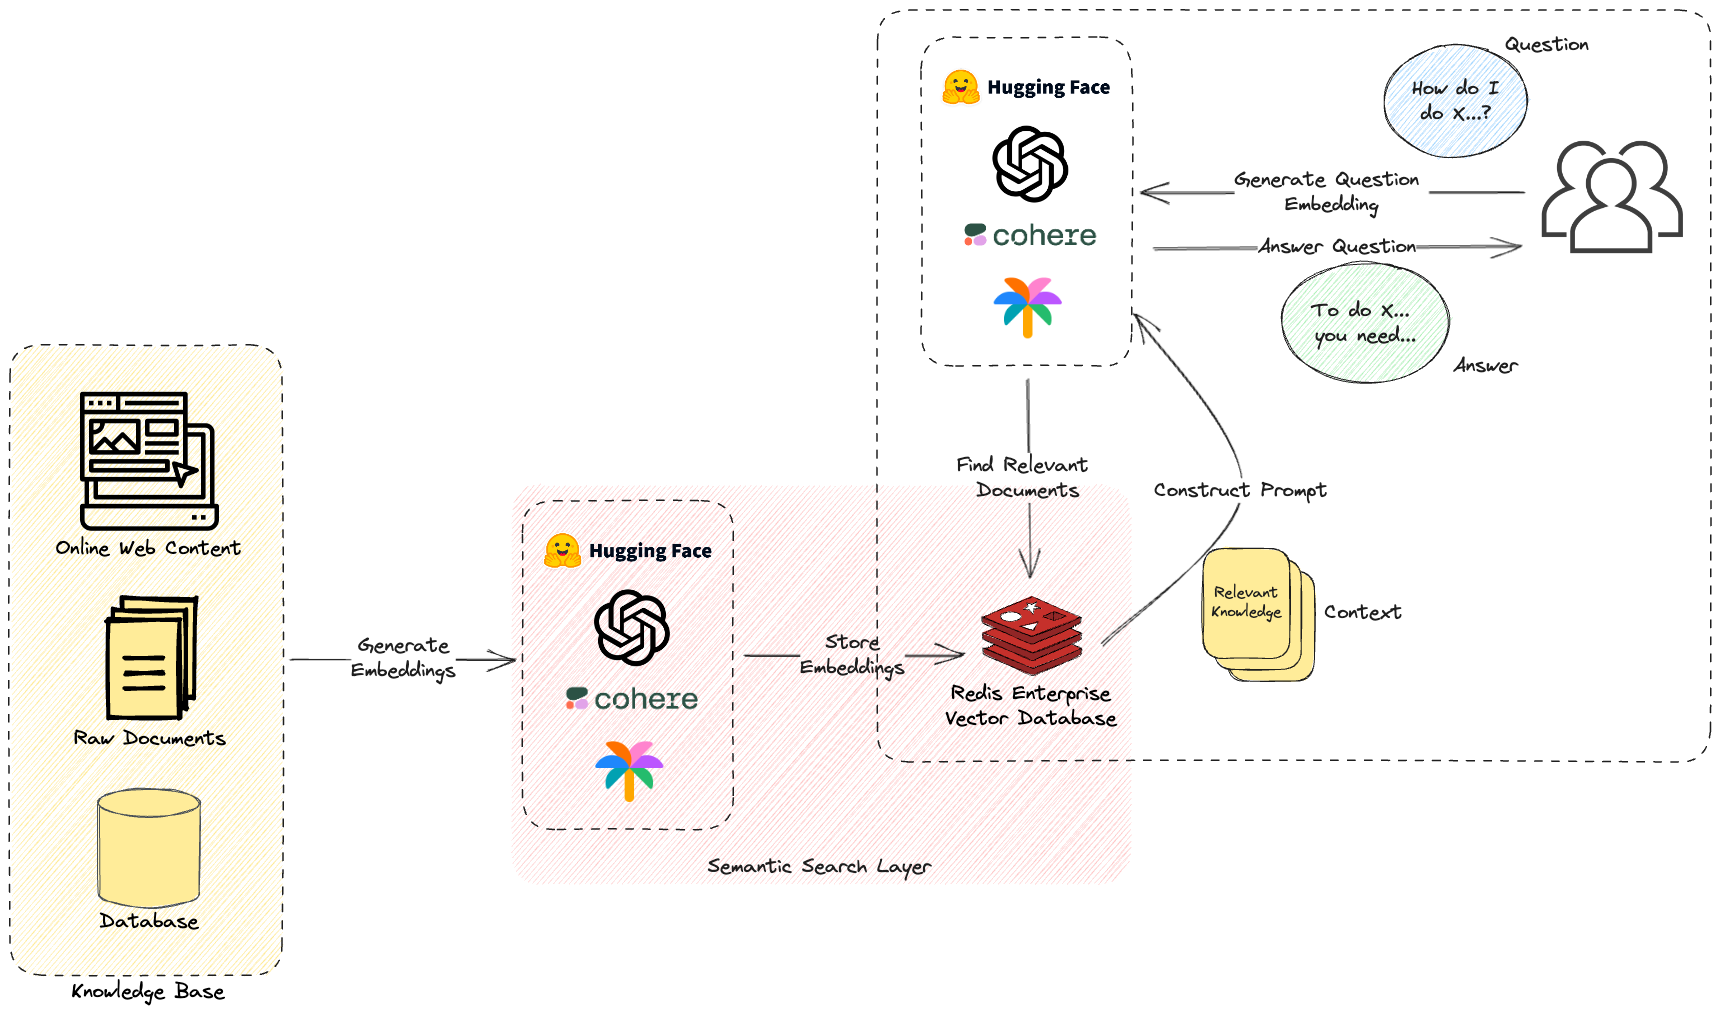

In [ ]:
def respond(request, chat_history):
    result  = ask_claude_semantic(request)
    chat_history.append((request, result))
    return "", chat_history

with gr.Blocks() as demo:
    chatbot = gr.Chatbot(height=240)
    msg = gr.Textbox(label="Prompt")
    btn = gr.Button("Submit")
    clear = gr.ClearButton(components=[msg, chatbot], value="Clear console")
    btn.click(respond, [msg, chatbot], [msg, chatbot])
    msg.submit(respond, [msg, chatbot], [msg, chatbot]) #Press enter to submit
    #hst = gr.Dataset(label='Chat History', components=[gr.Markdown()], samples=history)

gr.close_all()
demo.launch()